In [2]:
from clearml.task import Task
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_style("whitegrid")
sns.set_palette("muted")

# Get tasks

In [3]:
tasks = Task.get_tasks(project_name="lie-pose-net", task_filter={"system_tags": ["-archived"]})

In [4]:
completed_tasks = [x for x in tasks if x.status == "completed" or x.status == "published"]

In [5]:
completed_tasks[0].get_parameters()

{'General/activation': 'tanh',
 'General/batch_size': '64',
 'General/bias': 'True',
 'General/check_val_every_n_epoch': '2',
 'General/checkpoint_every_n_val_epochs': '10',
 'General/criterion/name': 'SE3Criterion',
 'General/criterion/rotation_koef': '-3.0',
 'General/criterion/translation_koef': '-3.0',
 'General/data_path': '/media/mikhail/Data3T/7scenes',
 'General/drop_rate': '0',
 'General/feature_dimension': '2048',
 'General/feature_extractor/pretrained': 'True',
 'General/gpus': '1',
 'General/image_size': '256',
 'General/max_epochs': '100',
 'General/name': 'PoseNet',
 'General/num_workers': '4',
 'General/optimizer/betas': '0.9 0.999',
 'General/optimizer/lr': '0.0001',
 'General/optimizer/weight_decay': '0.0005',
 'General/pretrained': 'True',
 'General/scene': 'fire',
 'General/scheduler/gamma': '0.5',
 'General/scheduler/step_size': '20',
 'General/use_test': 'True'}

In [6]:
completed_tasks[0].get_last_scalar_metrics()

{'hp_metric': {'hp_metric': {'last': -1.0, 'min': -1.0, 'max': -1.0}},
 'epoch': {'epoch': {'last': 99.0, 'min': 1.0, 'max': 99.0}},
 'train_loss': {'train_loss': {'last': -9.336409,
   'min': -9.386719,
   'max': -8.17259}},
 'median_position_error': {'median_position_error': {'last': 0.35012203,
   'min': 0.32368505,
   'max': 0.36899588}},
 'val_loss': {'val_loss': {'last': -5.30872,
   'min': -5.426328,
   'max': -4.694355}},
 'median_rotation_error': {'median_rotation_error': {'last': 12.969347,
   'min': 11.642302,
   'max': 15.226498}},
 'position_error': {'position_error': {'last': 0.37688214,
   'min': 0.37303966,
   'max': 0.41400138}},
 'rotation_error': {'rotation_error': {'last': 17.524416,
   'min': 16.719898,
   'max': 20.259058}},
 ':monitor:machine': {'network_rx_mbs': {'last': 0.007,
   'min': 0.004,
   'max': 1.212},
  'io_read_mbs': {'last': 0.001, 'min': 0.0, 'max': 111.045},
  'io_write_mbs': {'last': 0.646, 'min': 0.216, 'max': 9.437},
  'memory_free_gb': {'last'

# Analyse lie pose net

In [7]:
task_dict = {x.id: x for x in completed_tasks}

In [8]:
parameters = [x.get_parameters() for x in completed_tasks]
task_data = pd.DataFrame({
    "id": [x.id for x in completed_tasks],
    "criterion": [x.get_parameters()["General/criterion/name"] for x in completed_tasks],
    "epoch": [x.get_last_scalar_metrics()["epoch"]["epoch"]["last"] for x in completed_tasks],
    "tags": [x.get_tags() for x in completed_tasks],
    "scene": [x.get_parameters()["General/scene"] for x in completed_tasks],
    "loss_type": [x.get("General/criterion/loss_type", "l2") for x in parameters],
    "trans_koef": [x.get("General/criterion/translation_koef", "l2") for x in parameters],
    "rot_koef": [x.get("General/criterion/rotation_koef", "l2") for x in parameters],
    "use_se3_translation": [x.get("General/criterion/use_se3_translation", "True") for x in parameters]
})

In [9]:
task_data

,id,criterion,epoch,tags,scene,loss_type,trans_koef,rot_koef,use_se3_translation
0,709cb7f341b74cf4b70c778465f6f1d4,SE3Criterion,99.0,[good],fire,l2,-3.0,-3.0,True
1,7311ce5ca25d4149b538ea7c2787af31,SE3Criterion,99.0,[good],chess,l2,-3.0,-3.0,True
2,2ca30c315011418688b544ac7faab15e,SE3Criterion,99.0,[good],heads,l2,-3.0,-3.0,True
3,72de21bc9cb9406eac80815afc96e461,SE3Criterion,99.0,[good],office,l2,-3.0,-3.0,True
4,a5fa8425e9ff41fcb262fc4b4442459b,SE3Criterion,99.0,[],redkitchen,l2,-3.0,-3.0,True
...,...,...,...,...,...,...,...,...,...
65,90903014e6134f84a8b8d7649063aa12,SimpleSE3Criterion,99.0,[good],office,l1,-3.0,0.0,False
66,9a40e3d5b2964a04a3e179e625b37b56,SimpleSE3Criterion,99.0,[good],heads,l1,-3.0,0.0,False
67,edcdd219fdad4c87b3824edaf3a9c0fc,SimpleSE3Criterion,99.0,[good],fire,l1,-3.0,0.0,False
68,6ed0a1936c9c4730ad04fd7952e03d0f,SimpleSE3Criterion,99.0,[good],chess,l1,-3.0,0.0,False


In [10]:
def filter_task_data(data):
    indexes = data["epoch"] >= 99
    indexes &= (data["criterion"] == "SE3Criterion") | (data["criterion"] == "PoseNetCriterion") | (data["criterion"] == "SimpleSE3Criterion")
    indexes &= ["good" in x for x in data["tags"]]
    return data[indexes]

In [11]:
filtred_task_data = filter_task_data(task_data)
filtred_task_data["criterion"] = [x["criterion"]+" "+x["loss_type"] for x in filtred_task_data.iloc()]
filtred_task_data["criterion"] = [x["criterion"]+" "+str(float(x["rot_koef"])) for x in filtred_task_data.iloc()]
filtred_task_data["criterion"] = [x["criterion"]+" "+str(float(x["trans_koef"])) for x in filtred_task_data.iloc()]
filtred_task_data["criterion"] = [x["criterion"]+" "+str(x["use_se3_translation"])
                                  for x in filtred_task_data.iloc()]
filtred_task_data

/tmp/ipykernel_72349/1007989488.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtred_task_data["criterion"] = [x["criterion"]+" "+x["loss_type"] for x in filtred_task_data.iloc()]
/tmp/ipykernel_72349/1007989488.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtred_task_data["criterion"] = [x["criterion"]+" "+str(float(x["rot_koef"])) for x in filtred_task_data.iloc()]
/tmp/ipykernel_72349/1007989488.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

,id,criterion,epoch,tags,scene,loss_type,trans_koef,rot_koef,use_se3_translation
0,709cb7f341b74cf4b70c778465f6f1d4,SE3Criterion l2 -3.0 -3.0 True,99.0,[good],fire,l2,-3.0,-3.0,True
1,7311ce5ca25d4149b538ea7c2787af31,SE3Criterion l2 -3.0 -3.0 True,99.0,[good],chess,l2,-3.0,-3.0,True
2,2ca30c315011418688b544ac7faab15e,SE3Criterion l2 -3.0 -3.0 True,99.0,[good],heads,l2,-3.0,-3.0,True
3,72de21bc9cb9406eac80815afc96e461,SE3Criterion l2 -3.0 -3.0 True,99.0,[good],office,l2,-3.0,-3.0,True
5,88d05e64f59447c7a066b3549a872022,SE3Criterion l2 -3.0 -3.0 True,99.0,[good],pumpkin,l2,-3.0,-3.0,True
6,15b63a4f6dbb4019893752574112bb65,SE3Criterion l2 -3.0 -3.0 True,99.0,[good],stairs,l2,-3.0,-3.0,True
7,21a1398c2ef34f48a80697012e71f77a,PoseNetCriterion l2 -3.0 0.0 True,99.0,[good],fire,l2,0,-3.0,True
8,75910c48878e4f00a86e31323641f836,PoseNetCriterion l2 -3.0 0.0 True,99.0,[good],stairs,l2,0.0,-3.0,True
9,9ea1ba38216e408987aecdfbdf950ae6,PoseNetCriterion l2 -3.0 0.0 True,99.0,[good],chess,l2,0,-3.0,True
10,44d9030cf4ca45f5a8aa98307806f505,PoseNetCriterion l2 -3.0 0.0 True,99.0,[good],pumpkin,l2,0,-3.0,True


In [12]:
def get_metric_data(scalars, metric):
    data = pd.DataFrame({
        metric: scalars[metric][metric]["y"], 
        "iteration": scalars[metric][metric]["x"]
    }).set_index("iteration")
    return data

def get_several_metric_data(scalars, metrics):
    data = get_metric_data(scalars, metrics[0])
    for metric in metrics[1:]:
        data = data.join(get_metric_data(scalars, metric))
    return data

def add_column(data, column, value):
    data_length = len(data.index)
    data[column] = pd.Series([value for _ in range(data_length)])
    return data

In [13]:
experiment_data = pd.DataFrame()
for task_row in filtred_task_data.iloc:
    task = task_dict[task_row.id]
    reported_scalars = task.get_reported_scalars()
    data = get_several_metric_data(reported_scalars, ["epoch", "median_position_error", 
                                                                 "median_rotation_error", "val_loss"])
    data = data[~data.isnull().any(axis=1)].reset_index()
    data = add_column(data, "scene", task_row.scene)
    data = add_column(data, "criterion", task_row.criterion)
    data = add_column(data, "id", task_row.criterion)
    experiment_data = experiment_data.append(data)

In [14]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=100)
# sns.lineplot(data=experiment_data, x="epoch", y="median_position_error", ax=ax, hue="scene", style="criterion")

In [15]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=100)
# sns.lineplot(data=experiment_data, x="epoch", y="median_rotation_error", ax=ax, hue="scene", style="criterion")

<AxesSubplot:xlabel='epoch', ylabel='median_position_error'>

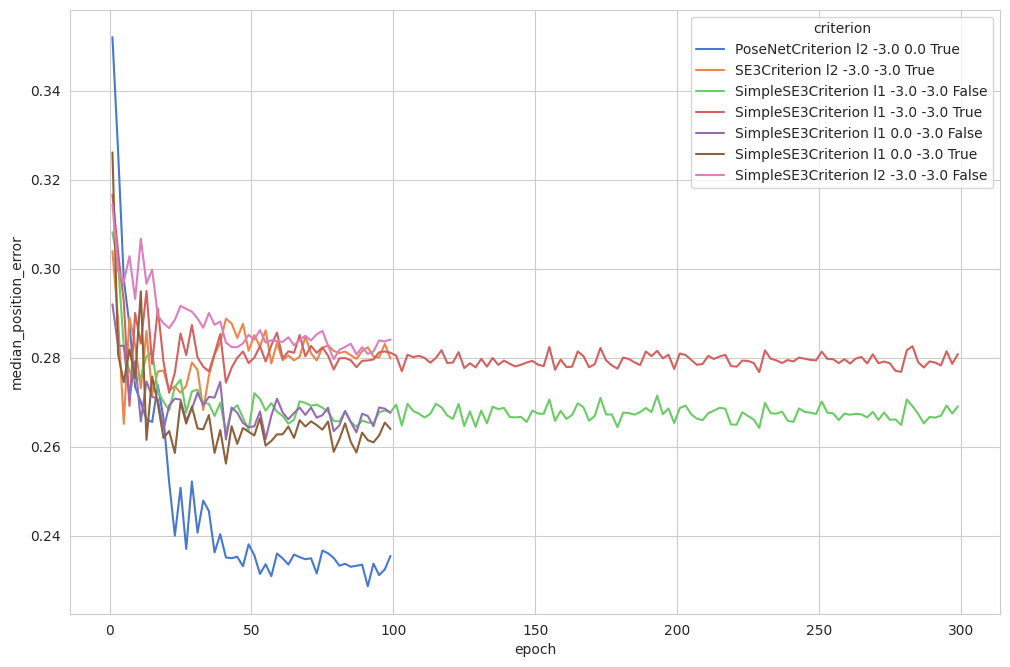

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=100)
mean_trajectory_data = experiment_data.pivot_table(index=["epoch", "criterion"], values=["median_rotation_error", 
                                                                      "median_position_error"])
sns.lineplot(data=mean_trajectory_data, x="epoch", y="median_position_error", ax=ax, hue="criterion")

<AxesSubplot:xlabel='epoch', ylabel='median_rotation_error'>

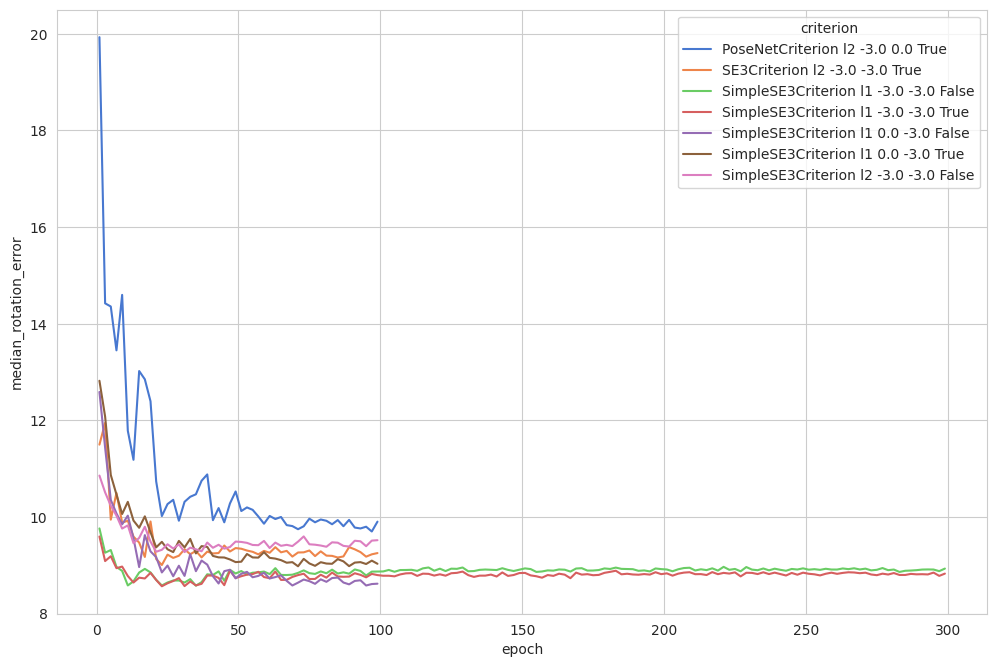

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=100)
sns.lineplot(data=mean_trajectory_data, x="epoch", y="median_rotation_error", ax=ax, hue="criterion")

<AxesSubplot:xlabel='epoch', ylabel='val_loss'>

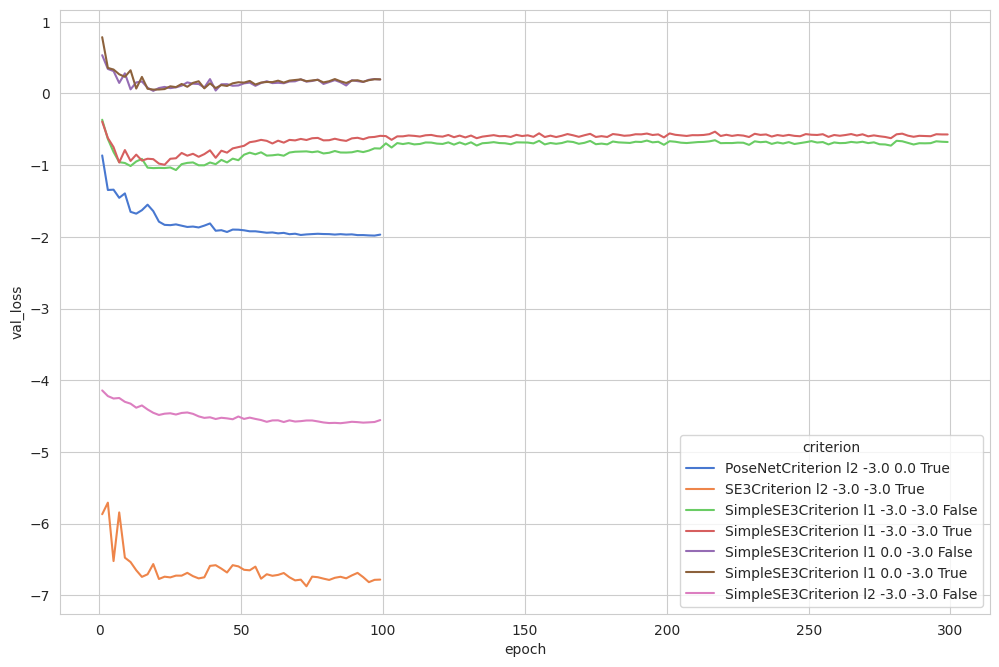

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=100)
mean_trajectory_data = experiment_data.pivot_table(index=["epoch", "criterion"], values=["val_loss"])
sns.lineplot(data=mean_trajectory_data, x="epoch", y="val_loss", ax=ax, hue="criterion")

## 10 epochs

In [108]:
data_20epoch = experiment_data[(experiment_data["epoch"] < 14) & (experiment_data["epoch"] > 8)]
data_20epoch = experiment_data[(experiment_data["epoch"] == 9)]

<AxesSubplot:xlabel='scene', ylabel='median_rotation_error'>

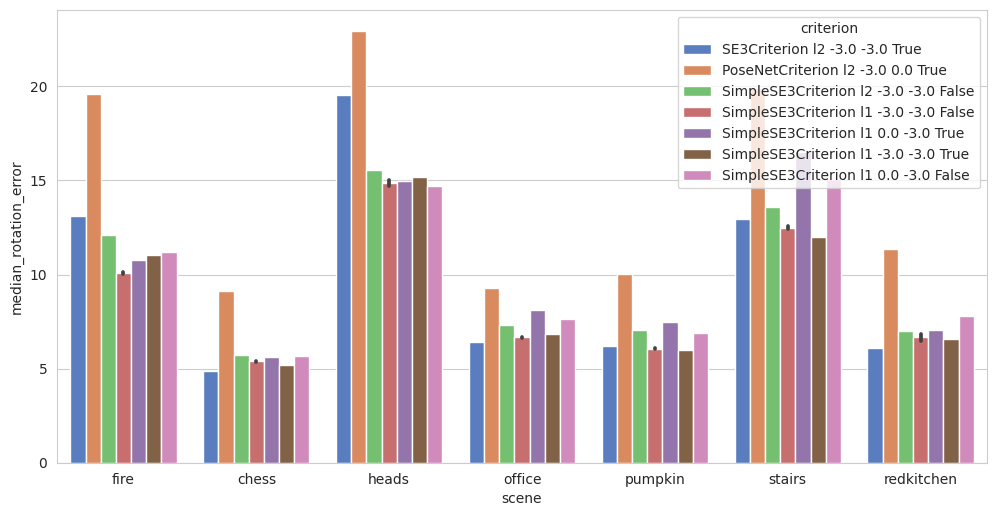

In [109]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
sns.barplot(x="scene", y="median_rotation_error", hue="criterion", data=data_20epoch, ax=ax)

<AxesSubplot:xlabel='scene', ylabel='median_position_error'>

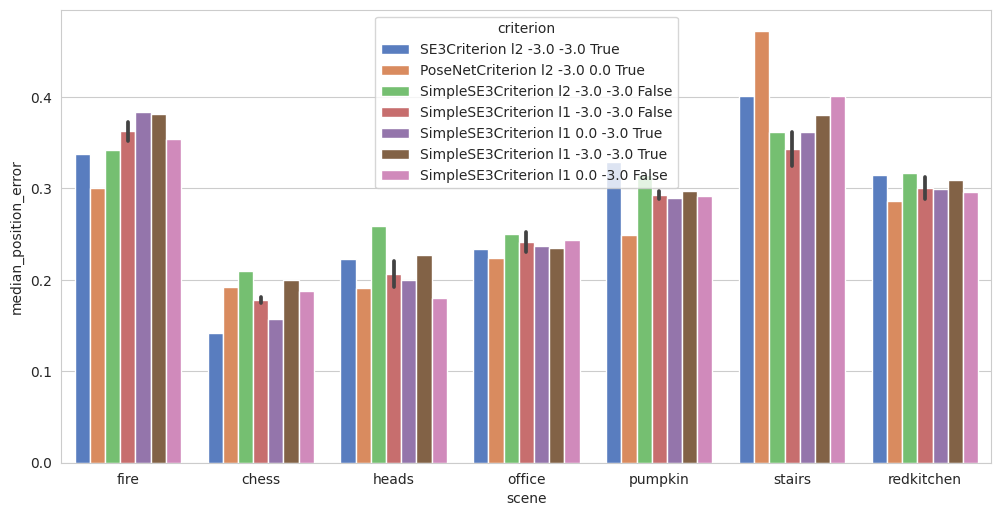

In [110]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
sns.barplot(x="scene", y="median_position_error", hue="criterion", data=data_20epoch, ax=ax)

In [111]:
low_epoch_result_data = data_20epoch.pivot_table(index=["scene"], 
                                         aggfunc=np.mean, 
                                         values=["median_rotation_error", "median_position_error"],
                                         columns=['criterion'])
low_epoch_result_data

median_position_error                                 \
criterion  PoseNetCriterion l2 -3.0 0.0 True SE3Criterion l2 -3.0 -3.0 True   
scene                                                                         
chess                               0.192390                       0.141860   
fire                                0.300356                       0.337781   
heads                               0.190915                       0.223221   
office                              0.223511                       0.233205   
pumpkin                             0.248662                       0.328385   
redkitchen                          0.286466                       0.314774   
stairs                              0.471735                       0.400578   

                                                  \
criterion  SimpleSE3Criterion l1 -3.0 -3.0 False   
scene                                              
chess                                   0.177820   
fire                                    0.362275   
heads                                   0.206606   
office                                  0.240966   
pumpkin                                 0.293016   
redkitchen                              0.300295   
stairs                                  0.342947   

                                                 \
criterion  SimpleSE3Criterion l1 -3.0 -3.0 True   
scene                                             
chess                                  0.200257   
fire                                   0.381326   
heads                                  0.227633   
office                                 0.234450   
pumpkin                                0.297004   
redkitchen                             0.309541   
stairs                                 0.379915   

                                                 \
criterion  SimpleSE3Criterion l1 0.0 -3.0 False   
scene                                             
chess                                  0.187387   
fire                                   0.353565   
heads                                  0.180151   
office                                 0.243899   
pumpkin                                0.291592   
redkitchen                             0.296265   
stairs                                 0.401339   

                                                \
criterion  SimpleSE3Criterion l1 0.0 -3.0 True   
scene                                            
chess                                 0.157220   
fire                                  0.383538   
heads                                 0.199937   
office                                0.236949   
pumpkin                               0.289798   
redkitchen                            0.299230   
stairs                                0.361210   

                                                  \
criterion  SimpleSE3Criterion l2 -3.0 -3.0 False   
scene                                              
chess                                   0.209407   
fire                                    0.342187   
heads                                   0.258318   
office                                  0.250158   
pumpkin                                 0.314467   
redkitchen                              0.316696   
stairs                                  0.361124   

                       median_rotation_error                                 \
criterion  PoseNetCriterion l2 -3.0 0.0 True SE3Criterion l2 -3.0 -3.0 True   
scene                                                                         
chess                               9.112292                       4.887289   
fire                               19.587034                      13.109988   
heads                              22.922525                      19.545855   
office                              9.266153                       6.392393   
pumpkin                            10.045906                       6.181267   
redkitchen                         

In [112]:
result_data = data_20epoch.pivot_table(index=["scene", "criterion"], 
                                         aggfunc=np.mean, 
                                         values=["median_rotation_error", "median_position_error"])
result_data.pivot_table(index=["criterion"])

,median_position_error,median_rotation_error
criterion,,
PoseNetCriterion l2 -3.0 0.0 True,0.273433,14.597139
SE3Criterion l2 -3.0 -3.0 True,0.282829,9.885427
SimpleSE3Criterion l1 -3.0 -3.0 False,0.274847,8.885186
SimpleSE3Criterion l1 -3.0 -3.0 True,0.290018,8.975136
SimpleSE3Criterion l1 0.0 -3.0 False,0.279171,9.849488
SimpleSE3Criterion l1 0.0 -3.0 True,0.275412,10.062922
SimpleSE3Criterion l2 -3.0 -3.0 False,0.293194,9.761288


In [119]:
print(np.round(low_epoch_result_data["median_position_error"]["PoseNetCriterion l2 -3.0 0.0 True"], 2))

scene
chess         0.19
fire          0.30
heads         0.19
office        0.22
pumpkin       0.25
redkitchen    0.29
stairs        0.47
Name: PoseNetCriterion l2 -3.0 0.0 True, dtype: float64


## 100 epochs

<AxesSubplot:xlabel='scene', ylabel='median_rotation_error'>

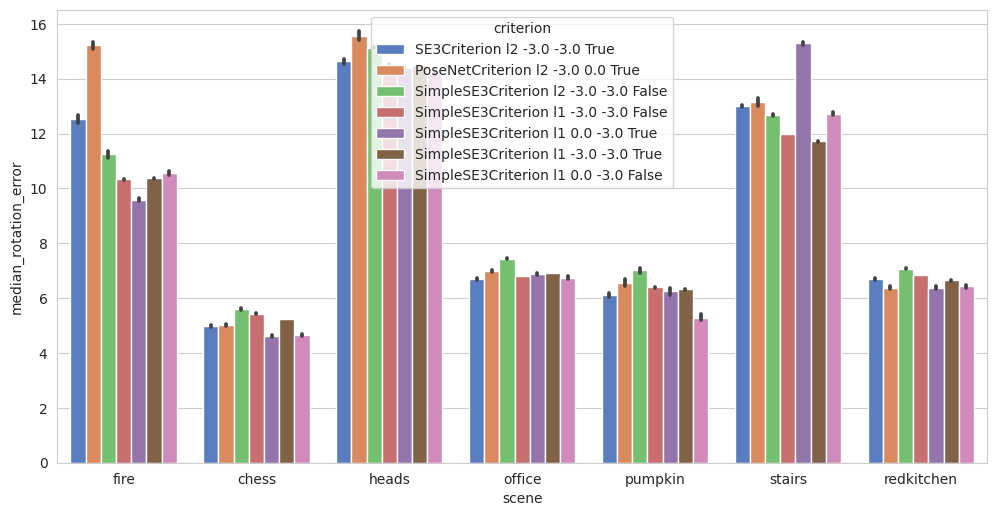

In [29]:
data = experiment_data[experiment_data["epoch"] > 80]
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
sns.barplot(x="scene", y="median_rotation_error", hue="criterion", data=data, ax=ax)

<AxesSubplot:xlabel='scene', ylabel='median_position_error'>

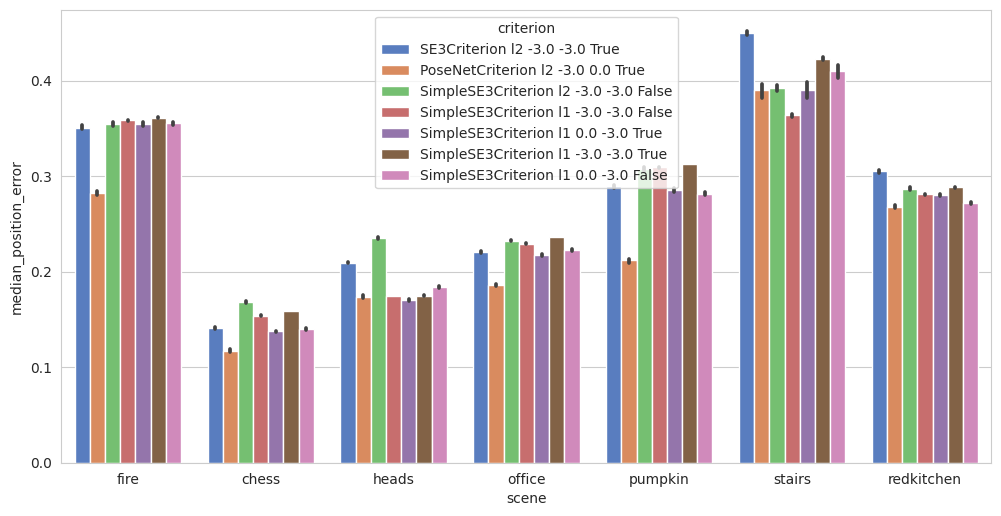

In [30]:
data = experiment_data[experiment_data["epoch"] > 80]
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
sns.barplot(x="scene", y="median_position_error", hue="criterion", data=data, ax=ax)

In [95]:
data = experiment_data[(experiment_data["epoch"] < 100) & (experiment_data["epoch"] > 80)]
result_data = data.pivot_table(index=["scene"], 
                                         aggfunc=np.mean, 
                                         values=["median_rotation_error", "median_position_error"],
                                         columns=['criterion'])
result_data
# data = data.applymap(lambda x: np.round(x, 3))

median_position_error                                 \
criterion  PoseNetCriterion l2 -3.0 0.0 True SE3Criterion l2 -3.0 -3.0 True   
scene                                                                         
chess                               0.117377                       0.140976   
fire                                0.282200                       0.350969   
heads                               0.173814                       0.209621   
office                              0.185890                       0.220744   
pumpkin                             0.211812                       0.289402   
redkitchen                          0.268019                       0.304935   
stairs                              0.390284                       0.450023   

                                                  \
criterion  SimpleSE3Criterion l1 -3.0 -3.0 False   
scene                                              
chess                                   0.154651   
fire                                    0.356865   
heads                                   0.177048   
office                                  0.229058   
pumpkin                                 0.305965   
redkitchen                              0.281030   
stairs                                  0.359969   

                                                 \
criterion  SimpleSE3Criterion l1 -3.0 -3.0 True   
scene                                             
chess                                  0.158133   
fire                                   0.361401   
heads                                  0.177126   
office                                 0.237797   
pumpkin                                0.314469   
redkitchen                             0.288977   
stairs                                 0.421288   

                                                 \
criterion  SimpleSE3Criterion l1 0.0 -3.0 False   
scene                                             
chess                                  0.139650   
fire                                   0.355232   
heads                                  0.184007   
office                                 0.223013   
pumpkin                                0.281828   
redkitchen                             0.271938   
stairs                                 0.409939   

                                                \
criterion  SimpleSE3Criterion l1 0.0 -3.0 True   
scene                                            
chess                                 0.137685   
fire                                  0.354806   
heads                                 0.170247   
office                                0.217545   
pumpkin                               0.285342   
redkitchen                            0.280541   
stairs                                0.390628   

                                                  \
criterion  SimpleSE3Criterion l2 -3.0 -3.0 False   
scene                                              
chess                                   0.168243   
fire                                    0.354602   
heads                                   0.235062   
office                                  0.232601   
pumpkin                                 0.307263   
redkitchen                              0.286674   
stairs                                  0.392402   

                       median_rotation_error                                 \
criterion  PoseNetCriterion l2 -3.0 0.0 True SE3Criterion l2 -3.0 -3.0 True   
scene                                                                         
chess                               5.010873                       4.969876   
fire                               15.216749                      12.539901   
heads                              15.565928                      14.635906   
office                              6.992270                       6.689986   
pumpkin                             6.567925                       6.130085   
redkitchen                         

In [32]:
result_data.pivot_table(index=["criterion"])

,median_position_error,median_rotation_error
criterion,,
PoseNetCriterion l2 -3.0 0.0 True,0.232771,9.841393
SE3Criterion l2 -3.0 -3.0 True,0.280953,9.239371
SimpleSE3Criterion l1 -3.0 -3.0 False,0.267229,8.903419
SimpleSE3Criterion l1 -3.0 -3.0 True,0.279416,8.816200
SimpleSE3Criterion l1 0.0 -3.0 False,0.266515,8.658448
SimpleSE3Criterion l1 0.0 -3.0 True,0.262399,9.054941
SimpleSE3Criterion l2 -3.0 -3.0 False,0.282407,9.456295


# 300 epochs

<AxesSubplot:xlabel='scene', ylabel='median_rotation_error'>

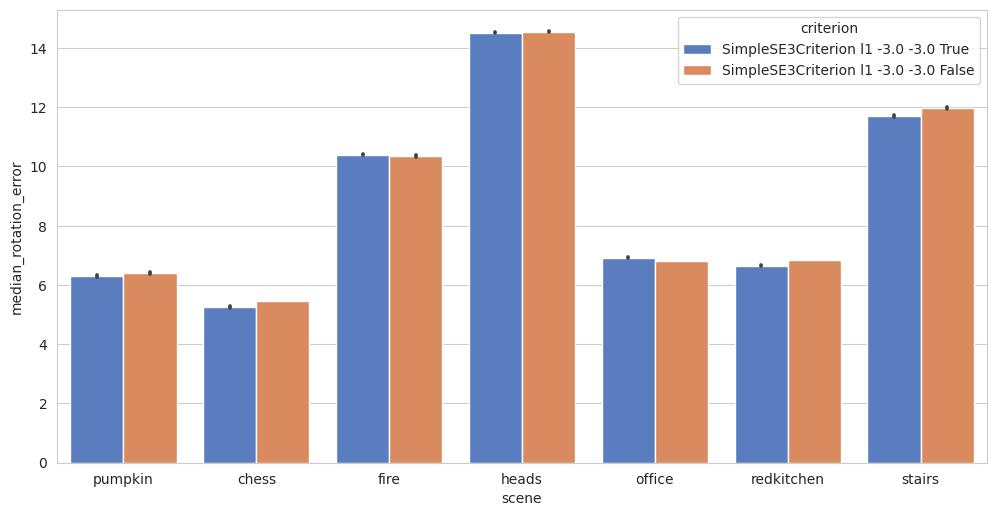

In [33]:
data_300epoch = experiment_data[experiment_data["epoch"] > 250]
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
sns.barplot(x="scene", y="median_rotation_error", hue="criterion", data=data_300epoch, ax=ax)

# Article table

## Plot

In [ ]:
short_critersion = {
    ""
}

In [53]:
short_criterions = {
    "PoseNetCriterion l2 -3.0 0.0 True": "PoseNet(logq)",
    "SimpleSE3Criterion l1 0.0 -3.0 False": "LiePoseNet l1",
    "SimpleSE3Criterion l2 -3.0 -3.0 False": "LiePoseNet l2"
}

In [71]:
def update_and_filter_criterion(data, short_criterions):
    criterions = [short_criterions.get(row["criterion"], "None") for row in data.iloc()]
    data["criterion"] = criterions
    data = data[data["criterion"] != "None"]
    return data

Text(0, 0.5, 'median rotation error (degree)')

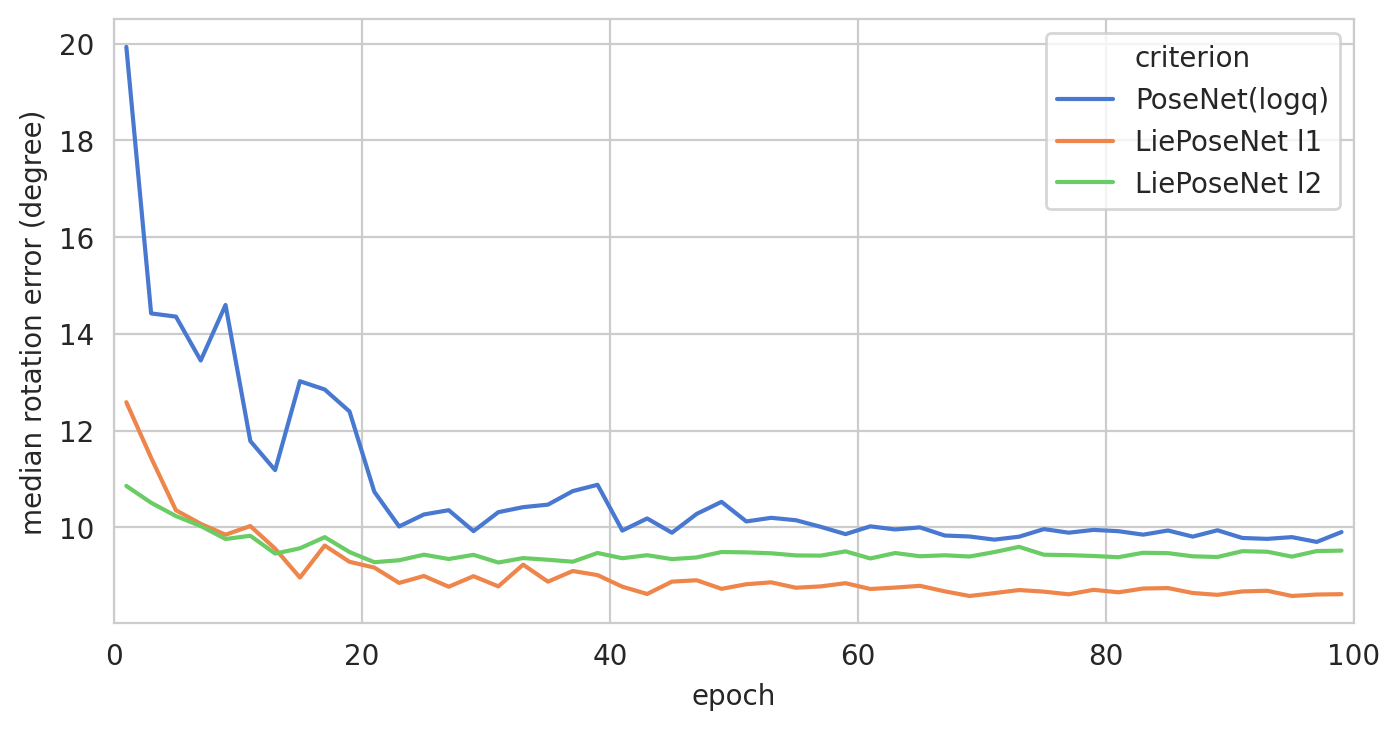

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=200)
mean_trajectory_data = experiment_data.pivot_table(index=["epoch", "criterion"], values=["median_rotation_error", 
                                                                      "median_position_error"]).reset_index()
mean_trajectory_data = update_and_filter_criterion(mean_trajectory_data, short_criterions)
sns.lineplot(data=mean_trajectory_data, x="epoch", y="median_rotation_error", ax=ax, hue="criterion")
ax.set_xlim(0, 100)
ax.set_ylabel("median rotation error (degree)")

## Bar

In [91]:
short_criterions = {
    "PoseNetCriterion l2 -3.0 0.0 True": "PoseNet(logq) 10 epoch",
    "SimpleSE3Criterion l1 0.0 -3.0 False": "LiePoseNet l1 10 epoch",
    "SimpleSE3Criterion l2 -3.0 -3.0 False": "LiePoseNet l2 10 epoch"
}
data_10epoch = experiment_data[experiment_data["epoch"] == 9]
data_10epoch = update_and_filter_criterion(data_10epoch, short_criterions)

scenes = ["chess", "fire", "heads", "office", "pumpkin", "redkitchen", "stairs"]
lstm_position = [0.24, 0.34, 0.21, 0.30, 0.33, 0.37, 0.4]
lstm_rotation = [5.77, 11.9, 13.7, 8.08, 7.00, 8.83, 13.7]
lstm_data_frame = pd.DataFrame({
    "scene": scenes,
    "median_position_error": lstm_position, 
    "median_rotation_error": lstm_rotation,
    "criterion": ["PoseNet LSTM 300 epoch"] * 7
})
data_10epoch = data_10epoch.append(lstm_data_frame)
data_10epoch

/tmp/ipykernel_72349/2101386092.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["criterion"] = criterions


,iteration,epoch,median_position_error,median_rotation_error,val_loss,scene,criterion,id
4,319.0,9.0,0.300356,19.587034,-0.701129,fire,PoseNet(logq) 10 epoch,PoseNetCriterion l2 -3.0 0.0 True
4,319.0,9.0,0.471735,19.903238,-0.987207,stairs,PoseNet(logq) 10 epoch,PoseNetCriterion l2 -3.0 0.0 True
4,629.0,9.0,0.192390,9.112292,-2.081456,chess,PoseNet(logq) 10 epoch,PoseNetCriterion l2 -3.0 0.0 True
4,629.0,9.0,0.248662,10.045906,-1.611794,pumpkin,PoseNet(logq) 10 epoch,PoseNetCriterion l2 -3.0 0.0 True
4,159.0,9.0,0.190915,22.922525,-0.814641,heads,PoseNet(logq) 10 epoch,PoseNetCriterion l2 -3.0 0.0 True
4,939.0,9.0,0.223511,9.266153,-1.951401,office,PoseNet(logq) 10 epoch,PoseNetCriterion l2 -3.0 0.0 True
4,1099.0,9.0,0.286466,11.342827,-1.610689,redkitchen,PoseNet(logq) 10 epoch,PoseNetCriterion l2 -3.0 0.0 True
4,319.0,9.0,0.342187,12.124592,-3.922297,fire,LiePoseNet l2 10 epoch,SimpleSE3Criterion l2 -3.0 -3.0 False
4,629.0,9.0,0.209407,5.737205,-5.362675,chess,LiePoseNet l2 10 epoch,SimpleSE3Criterion l2 -3.0 -3.0 False
4,1099.0,9.0,0.316696,6.978666,-2.906492,redkitchen,LiePoseNet l2 10 epoch,SimpleSE3Criterion l2 -3.0 -3.0 False


Text(0, 0.5, 'median rotation error (degree)')

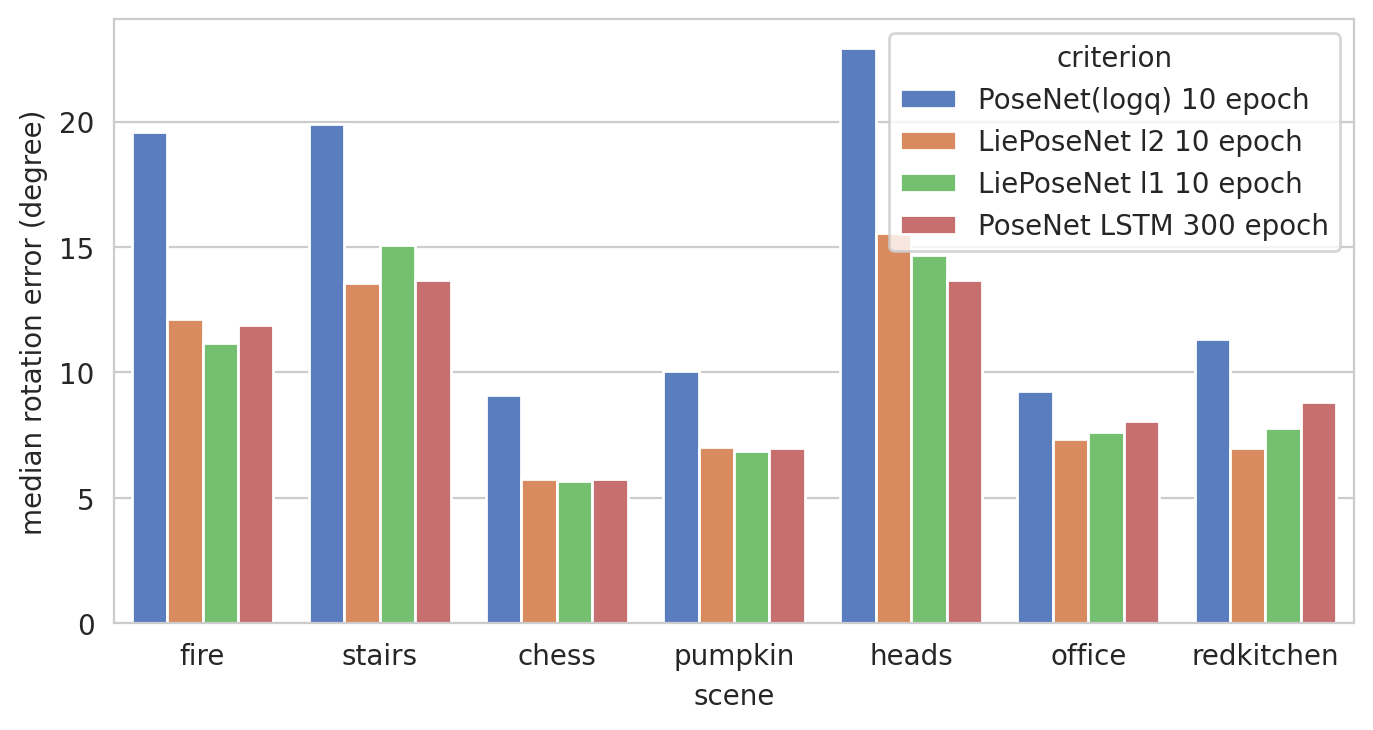

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=200)
sns.barplot(x="scene", y="median_rotation_error", hue="criterion", data=data_10epoch, ax=ax)
ax.set_ylabel("median rotation error (degree)")